In [20]:
!pip install torch torchvision transformers
!nvidea-smi

/bin/bash: line 1: nvidea-smi: command not found


In [32]:
from torchvision.models import resnet50
from transformers import ResNetForImageClassification
import torch.nn as nn
from torchvision import datasets, transforms
import torch
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
from IPython.display import display, clear_output
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the dataset
dataset = datasets.ImageFolder(root='/content/drive/MyDrive/TER/Medical_Waste_4.0_Previous_group', transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [24]:
model = resnet50(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Transfer the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
def index_to_class(index):
    # Check if the index is within the range of defined classes
    if index >= 0 and index < len(dataset.classes):
        return dataset.classes[index]
    else:
        return "False Prediction"  # Return a default label for out-of-range indices


In [26]:
import pandas as pd
import torch
from google.colab import files  # This line is only needed if you're using Google Colab

# Store predictions and labels
predictions = []
labels = []

# Predict using the model
with torch.no_grad():
    for inputs, label_indices in data_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted_indices = torch.max(outputs, 1)

        predictions.extend(predicted_indices.cpu().numpy())
        labels.extend(label_indices.numpy())

# Ensure the index_to_class function is correctly defined as shown above
# Map indices to class names
predicted_classes = [index_to_class(idx) for idx in predictions]
actual_classes = [index_to_class(idx) for idx in labels]

# Create DataFrame and save to CSV
results_df = pd.DataFrame({
    'Actual Class': actual_classes,
    'Predicted Class': predicted_classes
})
results_df.to_csv('/content/drive/MyDrive/TER/predictions-resnet50-not-finetuned.csv', index=False)


In [27]:
from sklearn.metrics import accuracy_score
from torch.nn.functional import cross_entropy

# Calculate accuracy
accuracy = accuracy_score(labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate loss
inputs, label_indices = next(iter(data_loader))  # Using one batch for example
inputs, label_indices = inputs.to(device), label_indices.to(device)
outputs = model(inputs)
loss = cross_entropy(outputs, label_indices)
print(f'Loss: {loss.item()}')


Accuracy: 0.05%
Loss: 15.572216987609863


In [38]:
data_path = '/content/drive/MyDrive/TER/predictions-resnet50-not-finetuned.csv'
results_df = pd.read_csv(data_path)

In [41]:
# Compute the confusion matrix
actual = results_df['Actual Class']
predicted = results_df['Predicted Class']
unique_labels = np.unique(actual)  # Unique actual labels
predicted_labels = np.unique(predicted)  # Unique predicted labels, could include 'No Prediction'

# Ensure "No Prediction" is included in the predicted labels for the matrix
if "No Prediction" not in predicted_labels:
    predicted_labels = np.append(predicted_labels, "False Prediction")

cm = confusion_matrix(actual, predicted, labels=np.append(unique_labels, "False Prediction"))


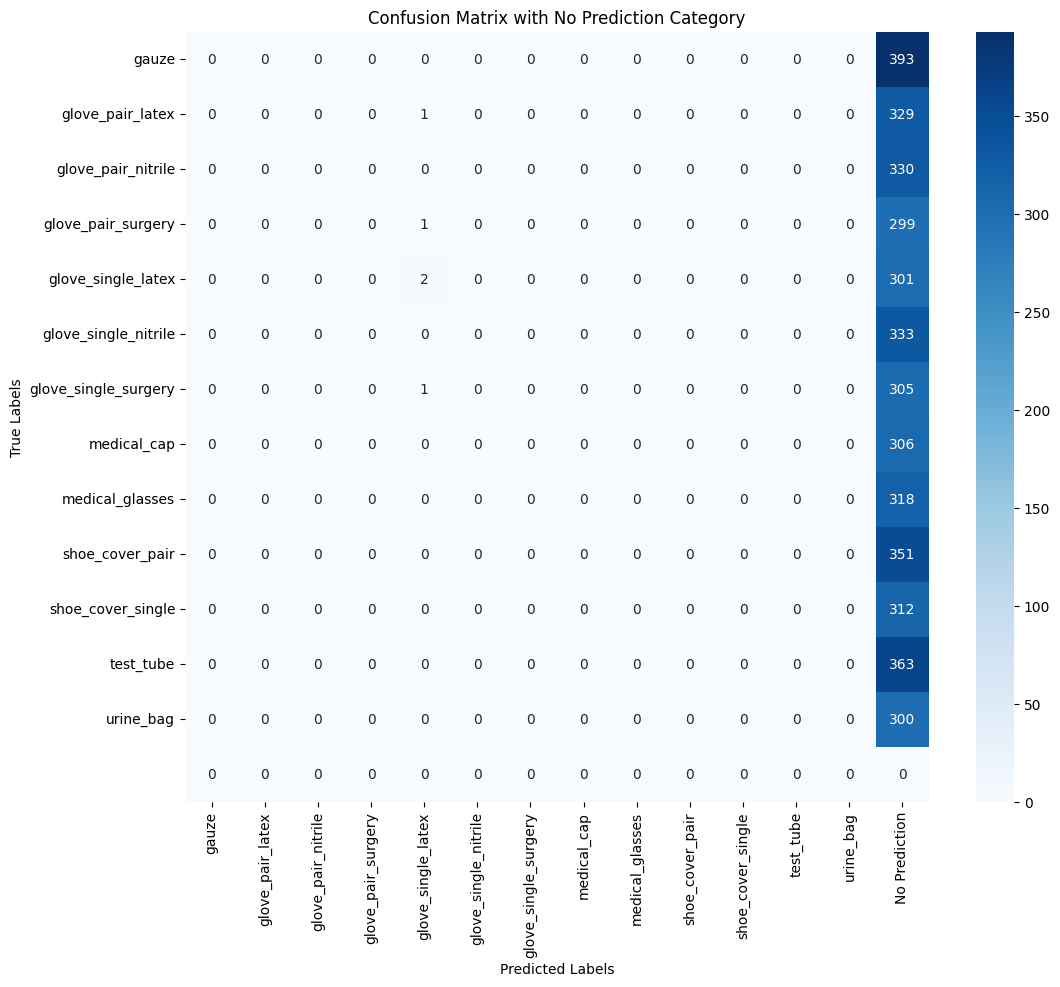

In [42]:
plt.figure(figsize=(12, 10))  # Adjust size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.append(unique_labels, "No Prediction"), yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with No Prediction Category')
plt.show()